In [ ]:
import gradio
from fastai.vision.all import *

In [2]:
MODELS_PATH = Path("./models")
EXAMPLES_PATH = Path('./examples')

In [3]:
learn = load_learner(MODELS_PATH/'model.pkl')

In [4]:
labels = learn.dls.vocab
labels

['Negative', 'Positive']

In [5]:
def predict(img):
    img = PILImage.create(img)
    _pred, _pred_w_idx, probs = learn.predict(img)
    labels_probs = {labels[i]: float(probs[i]) for i, _ in enumerate(labels)}
    return labels_probs

In [6]:
with open('gradio_article.md') as f:
    article = f.read()

In [7]:
interface_options = {
    "title": "RSNA Pneumonia Detection",
    "description": "An algorithm that automatically detects potential pneumonia cases",
    "article": article,
    "examples": [f'{EXAMPLES_PATH}/{f.name}' for f in EXAMPLES_PATH.iterdir()],
    "layout": "horizontal",
    "theme": "default",
}

demo_options = {
    "inline": False,
    "inbrowser": True,
    "share": False,
    "show_error": True,
    "server_name": "0.0.0.0",
    "server_port": 9999,
    "enable_queue": True,
}

# demo = gradio.Interface(fn=predict,
#                       inputs=gradio.inputs.Image(shape=(512, 512)),
#                       outputs=gradio.outputs.Label(num_top_classes=5),
#                       **interface_options)

# demo.launch(**demo_options)

In [109]:
examples = [f'{EXAMPLES_PATH}/{f.name}' for f in EXAMPLES_PATH.iterdir()]
from random import choice

example = choice(examples)
img = PILImage.create(example)


In [110]:
x, = first(learn.dls.test_dl([img]))
with torch.no_grad():
    output = learn.model.eval()(x)
cls = int(output.argmax())
learn.dls.vocab[cls]

'Positive'

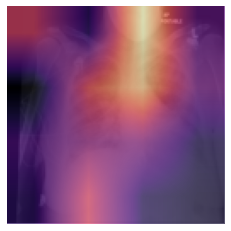

In [111]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

x_dec = TensorImage(learn.dls.train.decode((x,))[0][0])
with HookBwd(learn.model[0].model.layer4) as hookg:
    with Hook(learn.model[0].model.layer4]) as hook:
        output = learn.model.eval()(x)
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.7, extent=(0,128,128,0),
              interpolation='bilinear', cmap='magma');

In [49]:
learn.model[0].model.layer4

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_block): Identity()
    (act2): ReLU(inplace=True)
    (aa): Identity()
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=

In [17]:
def predict(img):
    img = PILImage.create(img)
    _pred, _pred_w_idx, probs = learn.predict(img)
    labels_probs = {labels[i]: float(probs[i]) for i, _ in enumerate(labels)}


    x, = first(learn.dls.test_dl([img]))
    x_dec = TensorImage(learn.dls.train.decode((x,))[0][0])
    with HookBwd(learn.model[0].model.layer4) as hookg:
        with Hook(learn.model[0].model.layer4) as hook:
            output = learn.model.eval()(x)
            act = hook.stored
        output[0,cls].backward()
        grad = hookg.stored

    w = grad[0].mean(dim=[1,2], keepdim=True)
    cam_map = (w * act[0]).sum(0)

    _,ax = plt.subplots()
    x_dec.show(ctx=ax)
    ax.imshow(cam_map.detach().cpu(), alpha=0.7, extent=(0,128,128,0),
                interpolation='bilinear', cmap='magma');
    plt.savefig("gradcam.jpg", format="jpg")
    plt.close()
    
    return labels_probs, Path("gradcam.jpg")

demo = gradio.Interface(fn=predict,
                      inputs=gradio.inputs.Image(shape=(512, 512)),
                      outputs=[gradio.outputs.Label(num_top_classes=5, label="Detected Class"),
                                gradio.outputs.Image(type="filepath", label="GradCAM")],
                      **interface_options)

demo.launch(**demo_options)

/tmp/ipykernel_365035/2218158489.py:29: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gradio.inputs.Image(shape=(512, 512)),
/tmp/ipykernel_365035/2218158489.py:29: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gradio.inputs.Image(shape=(512, 512)),
/tmp/ipykernel_365035/2218158489.py:30: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs=[gradio.outputs.Label(num_top_classes=5, label="Detected Class"),
/tmp/ipykernel_365035/2218158489.py:30: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  outputs=[gradio.outputs.Label(num_top_classes=5, label="Detected Class"),
/tmp/ipykernel_365035/2218158489.py:31: GradioDeprecationWarning: Usage of gradio.outpu

Running on local URL:  http://0.0.0.0:9999

To create a public link, set `share=True` in `launch()`.


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1052: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
